In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from carps.analysis.gather_data import normalize_logs, get_interpolated_performance_df

In [3]:
def load_set(paths: list[str], set_id: str = "unknown") -> tuple[pd.DataFrame, pd.DataFrame]:
    logs = []
    for p in paths:
        fn = Path(p) / "trajectory.parquet"
        if not fn.is_file():
            fn = Path(p) / "runs/logs.csv"
        logs.append(pd.read_csv(fn))

    df = pd.concat(logs).reset_index(drop=True)
    df_cfg = pd.concat([pd.read_csv(Path(p) / "runs/logs_cfg.csv") for p in paths]).reset_index(drop=True)
    df["set"] = set_id
    return df, df_cfg

In [4]:
PATH = '/scratch/hpc-prf-intexml/tklenke/experiment_runs/dacbo_piecewise_longer'
NAME = 'dacboenv'

In [5]:
def create_df():
    run_dirs = [(PATH, NAME)]
    dfs = [load_set(paths=[ps], set_id=set_id) for ps, set_id in run_dirs]

    df = pd.concat([d for d, _ in dfs]).reset_index(drop=True)
    df = normalize_logs(df)

    perf = get_interpolated_performance_df(df)

    perf_time = get_interpolated_performance_df(df, x_column="time_norm")

    perf.to_parquet(f'{PATH}/perf.parquet')
    perf_time.to_parquet(f'{PATH}/perf_time.parquet')

In [6]:
create_df()

[13:29:35] INFO     Start normalization...                                                       ]8;id=443203;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=943406;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#602\602]8;;\

           INFO     Normalize n_trials...                                                        ]8;id=340754;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=320387;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#603\603]8;;\

           INFO     Normalize cost...                                                            ]8;id=382954;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=513307;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#605\605]8;;\

           INFO     Calc normalized incumbent cost...                                            ]8;id=49362;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=343388;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#621\621]8;;\

           INFO     Normalize time...                                                            ]8;id=239581;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=851100;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#641\641]8;;\

           INFO     Done.                                                                        ]8;id=975677;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=275968;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#644\644]8;;\

           INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=845405;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=246694;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#718\718]8;;\
                    budget.                                                                                        

           INFO     Create dataframe for neat plotting by aligning x-axis / interpolating        ]8;id=155268;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py\gather_data.py]8;;\:]8;id=574951;file:///scratch/hpc-prf-intexml/tklenke/repos/dacboenv/.venv/lib/python3.12/site-packages/carps/analysis/gather_data.py#718\718]8;;\
                    budget.                                                                                        

In [28]:
# Data loading
df = pd.read_parquet(f'{PATH}/perf.parquet')

from ioh import get_problem, ProblemClass

best_1 = get_problem(1, 0, 2, ProblemClass.BBOB).optimum.y
best_8 = get_problem(8, 0, 2, ProblemClass.BBOB).optimum.y
best_20 = get_problem(20, 0, 2, ProblemClass.BBOB).optimum.y

def get_regret(row):
    if "/1" in row["task_id"]:
        return abs(row["trial_value__cost_inc"] - best_1)
    elif "/8" in row["task_id"]:
        return abs(row["trial_value__cost_inc"] - best_8)
    elif "/20" in row["task_id"]:
        return abs(row["trial_value__cost_inc"] - best_20)
    else:
        return None

df["regret"] = df.apply(get_regret, axis=1)
df["log_regret"] = df["regret"].map(lambda x: np.log(x + 1e-10))

In [8]:
final = pd.DataFrame(columns=['optimizer_id', 'task_id', 'incumbent_value', 'seed'])

for problem in df['task_id'].unique():
    filtered = df[df['task_id'] == problem]

    incumbents = filtered.groupby(["optimizer_id", "seed"])["trial_value__cost_inc"].min().reset_index()
    incumbents.columns = ['optimizer_id', 'seed', 'incumbent_value']
    incumbents['task_id'] = problem

    final = pd.concat([final, incumbents], ignore_index=True)

final.to_csv(f'{PATH}/final.csv')

/tmp/ipykernel_4161001/2282343157.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  final = pd.concat([final, incumbents], ignore_index=True)


In [9]:
final = pd.read_csv(f'{PATH}/final.csv')

In [10]:
FIGURE_PATH = '../figures'

/tmp/ipykernel_4161001/1669540267.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


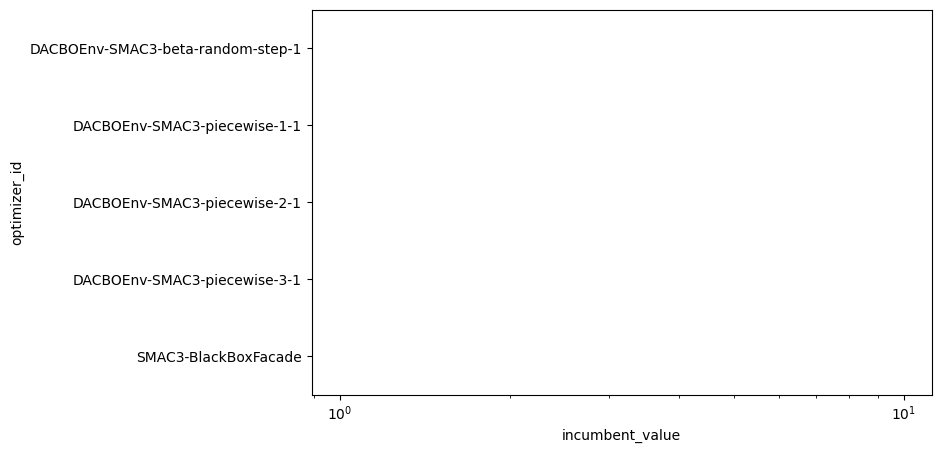

In [11]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=final[final["task_id"].str.endswith("/1/0")], x='incumbent_value', y='optimizer_id', hue='optimizer_id')
plt.xscale('log')
#plt.savefig(f'{FIGURE_PATH}/learned_policies/1.pdf', bbox_inches='tight')
plt.show()

/tmp/ipykernel_4161001/3810440260.py:3: UserWarning: Data has no positive values, and therefore cannot be log-scaled.
  plt.xscale('log')


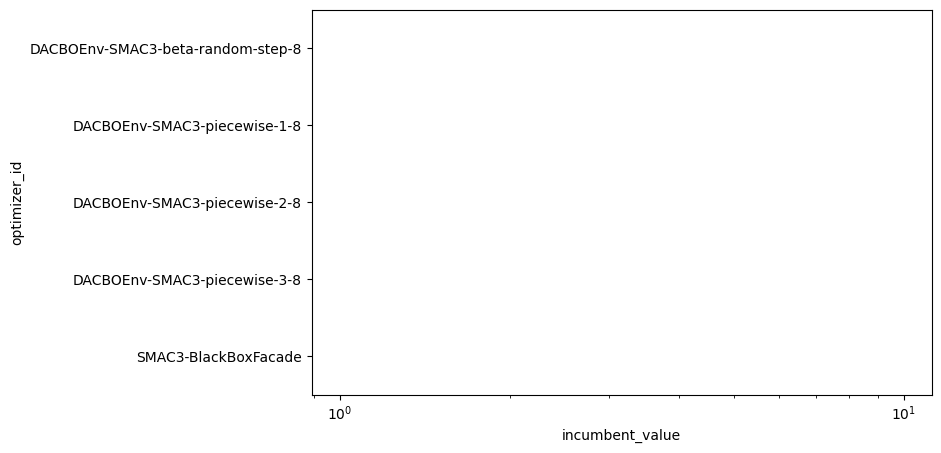

In [12]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=final[final["task_id"].str.endswith("/8/0")], x='incumbent_value', y='optimizer_id', hue='optimizer_id')
plt.xscale('log')
#plt.savefig(f'{FIGURE_PATH}/learned_policies/1.pdf', bbox_inches='tight')
plt.show()

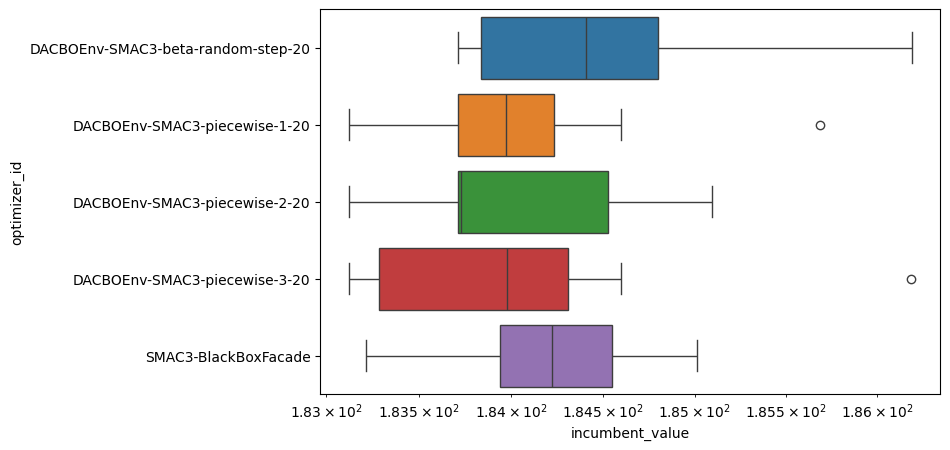

In [13]:
plt.figure(figsize=(8, 5))
sns.boxplot(data=final[final["task_id"].str.endswith("/20/0")], x='incumbent_value', y='optimizer_id', hue='optimizer_id')
plt.xscale('log')
#plt.savefig(f'{FIGURE_PATH}/learned_policies/1.pdf', bbox_inches='tight')
plt.show()

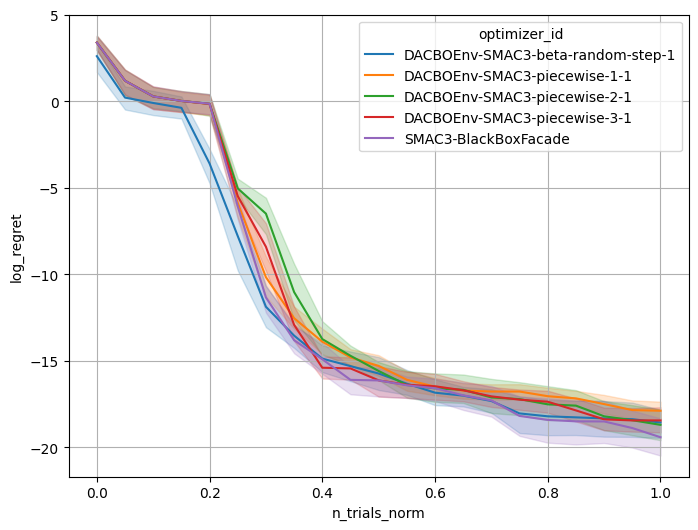

In [29]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/1/0")], x="n_trials_norm", y="log_regret", hue="optimizer_id")
# plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

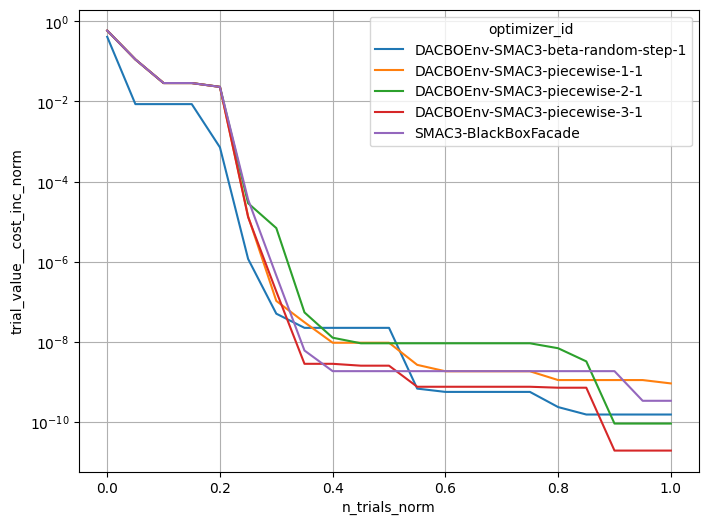

In [15]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/1/0") & (df["seed"] == 1)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

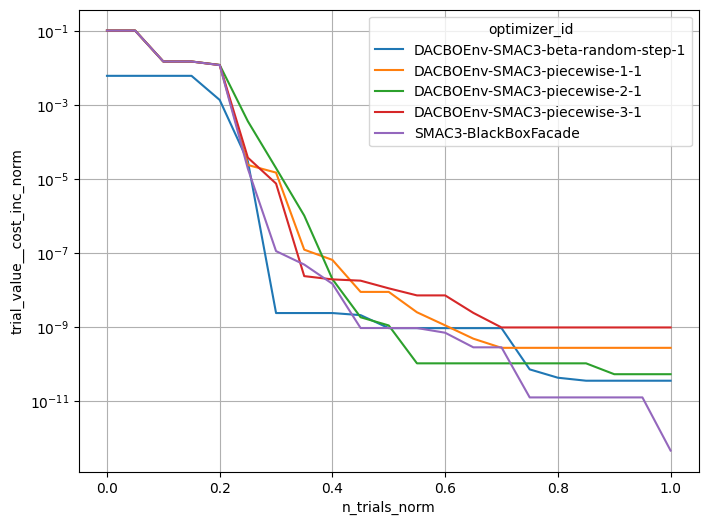

In [16]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/1/0") & (df["seed"] == 2)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

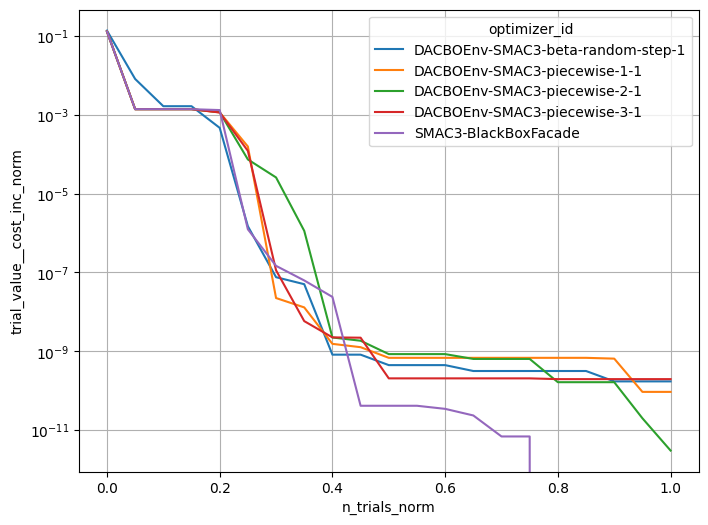

In [17]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/1/0") & (df["seed"] == 3)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

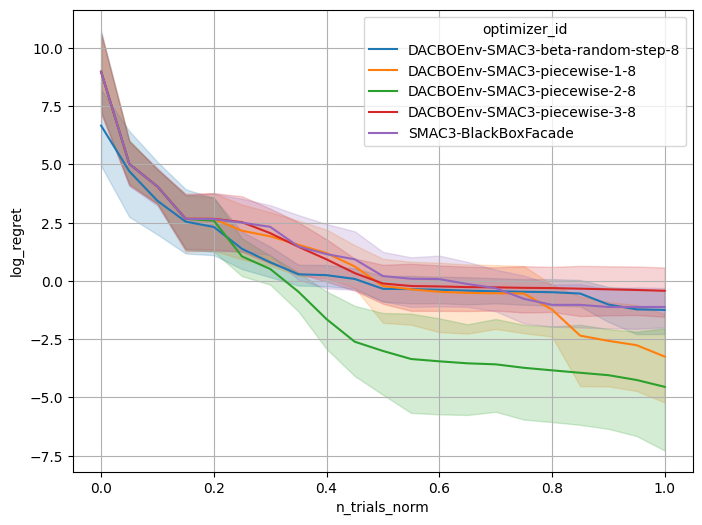

In [31]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/8/0")], x="n_trials_norm", y="log_regret", hue="optimizer_id")
# plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

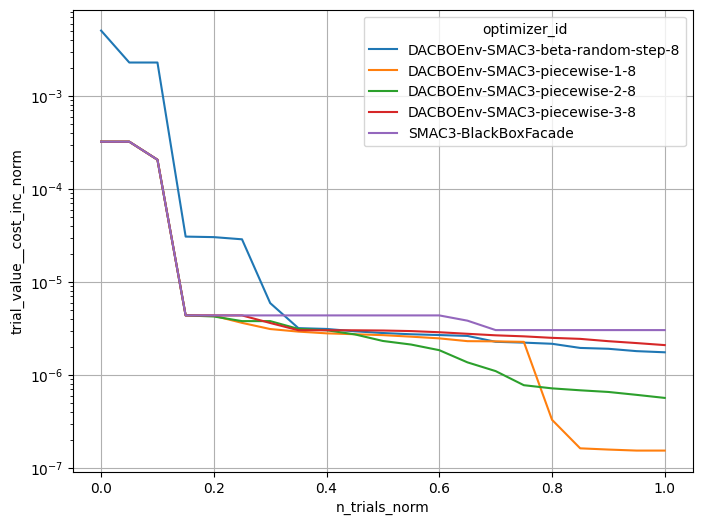

In [19]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/8/0") & (df["seed"] == 1)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

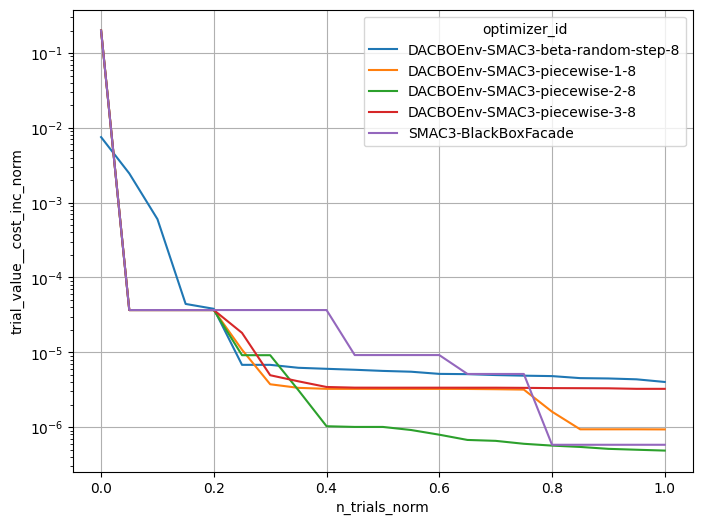

In [20]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/8/0") & (df["seed"] == 2)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

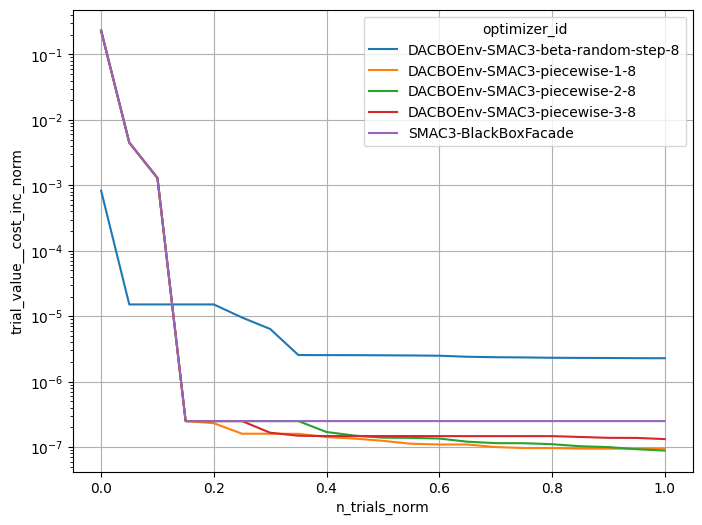

In [21]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/8/0") & (df["seed"] == 3)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)

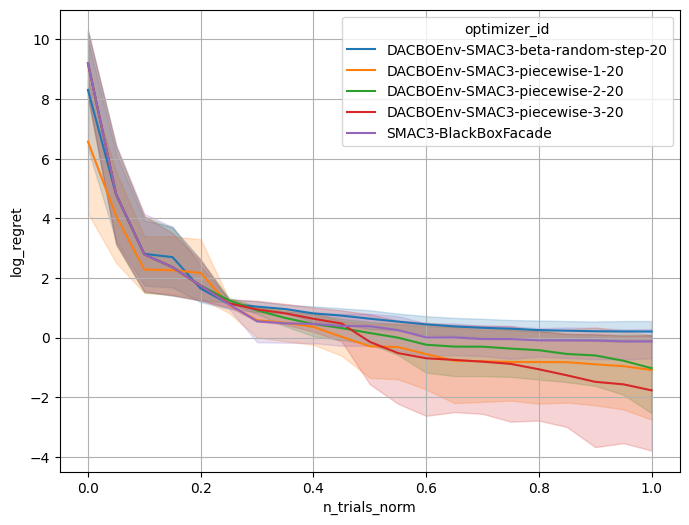

In [32]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/20/0")], x="n_trials_norm", y="log_regret", hue="optimizer_id")
# plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

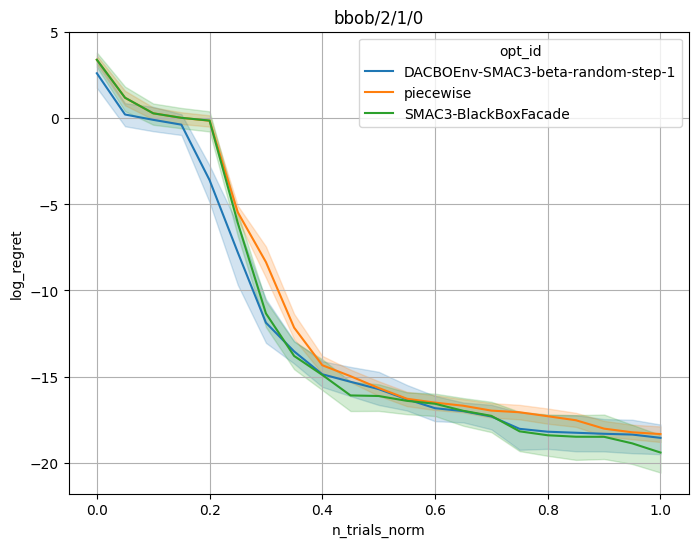

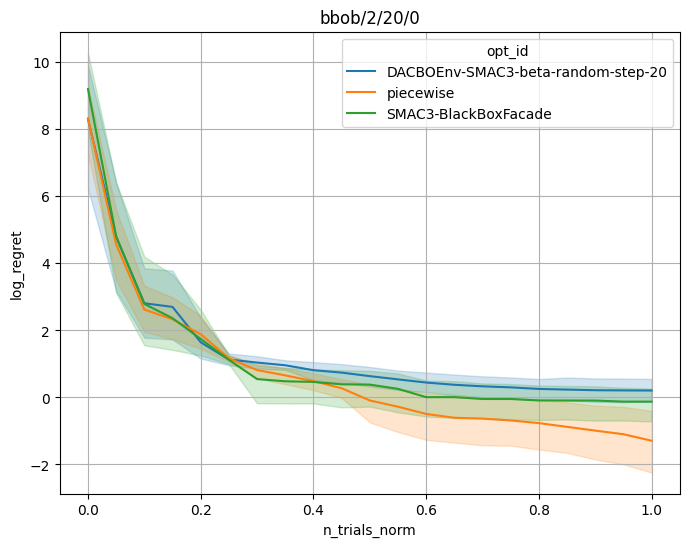

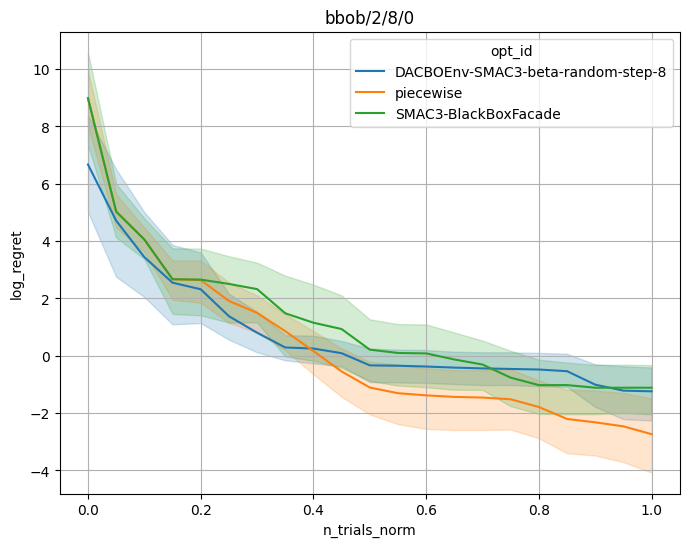

In [ ]:
plot_df = df.copy()
def rename(x):
    if "piecewise" in x:
        return "piecewise"
    return x
plot_df["opt_id"] = plot_df["optimizer_id"].apply(rename)
for task_id, gdf in plot_df.groupby("task_id"):
    plt.figure(figsize=(8, 6))
    sns.lineplot(data=gdf, x="n_trials_norm", y="log_regret", hue="opt_id")
    # plt.yscale("log")
    plt.grid(True)
    plt.title(task_id)

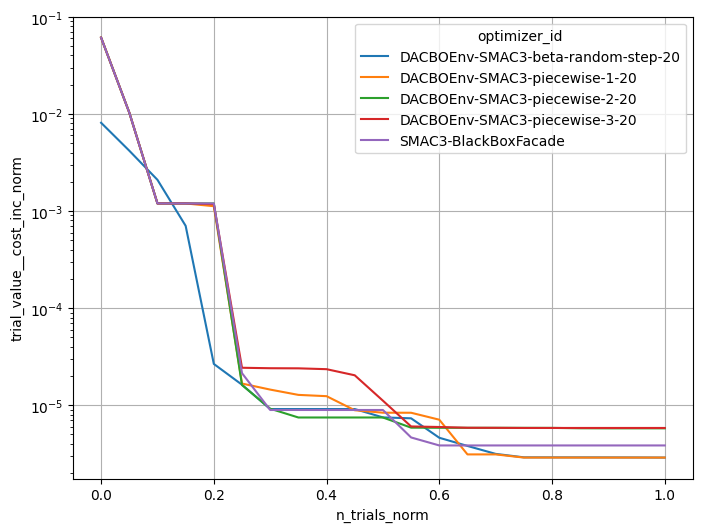

In [23]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/20/0") & (df["seed"] == 1)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

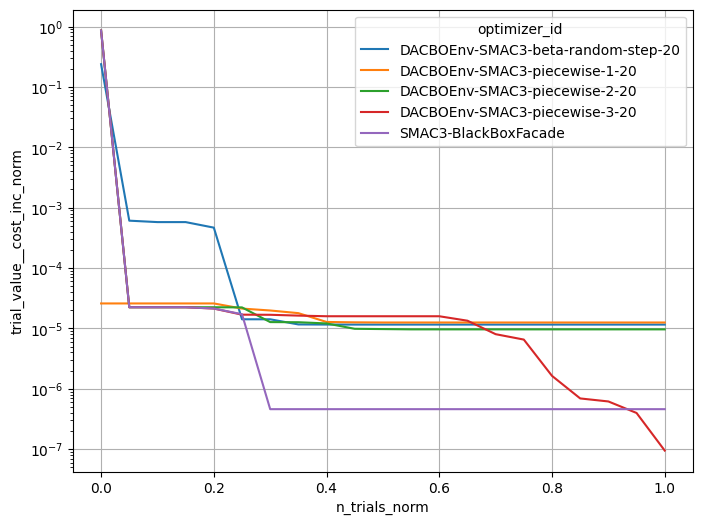

In [24]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/20/0") & (df["seed"] == 2)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')

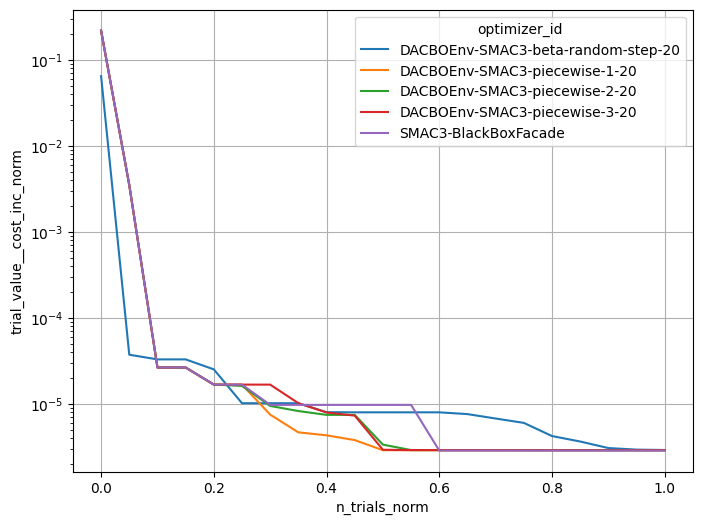

In [25]:
plt.figure(figsize=(8, 6))
sns.lineplot(data=df[df["task_id"].str.endswith("/20/0") & (df["seed"] == 3)], x="n_trials_norm", y="trial_value__cost_inc_norm", hue="optimizer_id")
plt.yscale("log")
plt.grid(True)
#plt.savefig(f'{FIGURE_PATH}/learned_policies/2.pdf', bbox_inches='tight')